In [1]:
from obspy.io.segy.core import _read_segy
import obspy
from scipy import fftpack
from scipy import signal
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
from obspy.signal import polarization as pol
from obspy.signal import rotate

from sklearn.preprocessing import normalize
from obspy.signal.filter import remez_fir
from obspy import UTCDateTime
from mpl_toolkits.mplot3d import Axes3D


In [2]:
data = _read_segy('11QAMS2017042315121094.sgy', unpack_trace_headers=True)

In [3]:
def plot_vib_data(stream):
    

    st = stream[6::].copy() #remove traces of first two geophones (acceleration) on surface, rest (velocity) downhole

    t = np.linspace(0, st[0].stats.endtime.second - st[0].stats.starttime.second,
                            st[0].stats.npts, endpoint=True )

    number_of_geophones = int(len(st)/3)
    fig, ax = plt.subplots(number_of_geophones,1,sharex= True, figsize=(14,12))

    fig.suptitle(str(st[0].stats.starttime)[:-8]+ "  -  "+str(st[0].stats.endtime)[:-8], fontsize=12)



    j=0 
    for i in range(number_of_geophones):
        if j <= (len(st)-3):
            #plot traces for each componenet
            ax[i].plot(t*1000, st[j].data, 'k', label= '$Z$')
            ax[i].plot(t*1000, st[j+1].data, 'r', label ='$H1$')
            ax[i].plot(t*1000, st[j+2].data, 'g', label= '$H2$')

            #plot p-wave pick if exist
            if st[i*3].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace !=0:
                ax[i].axvline(st[i*3].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace/1000,
                             lw=3)
            #plot s-wave pick if exist
            if st[i*3].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace !=0:
                ax[i].axvline(st[i*3].stats.segy.trace_header.y_coordinate_of_ensemble_position_of_this_trace/1000,
                           lw=3)

            #find min and max amplitude within each geophone
            maxVal = max([max(st[j].data),max(st[j+1].data), max(st[j+2].data), abs(min(st[j].data)),
                          abs(min(st[j+1].data)), abs(min(st[j+2].data))])

            plt.setp(ax[i].get_yticklabels(), visible=False)
            plt.setp(ax[i].get_yticklines(), visible=False)

            ax[i].set_ylabel('$well$ {}: $Geop$ {}'.format(st[i*3].stats.segy.trace_header.\
                                                           for_3d_poststack_data_this_field_is_for_cross_line_number,
                                                       st[i*3].stats.segy.trace_header.shotpoint_number),
                             fontsize=8, rotation='horizontal', verticalalignment='center',
                             horizontalalignment='right',)

            #find min and max amplitude within each geophone
            ax[i].spines['top'].set_color("none")
            ax[i].spines['bottom'].set_color("none")
            ax[i].spines['right'].set_color("none")

            ax[i].annotate('$\pm $ {:0.4f}'.format(maxVal), xy=(1, 0), xycoords='axes fraction', fontsize=8,
                    xytext=(0.89, 0.9))
            
            j+=3


    plt.xlabel('$Time (ms)$', fontsize=10) 
    # plt.legend()

    

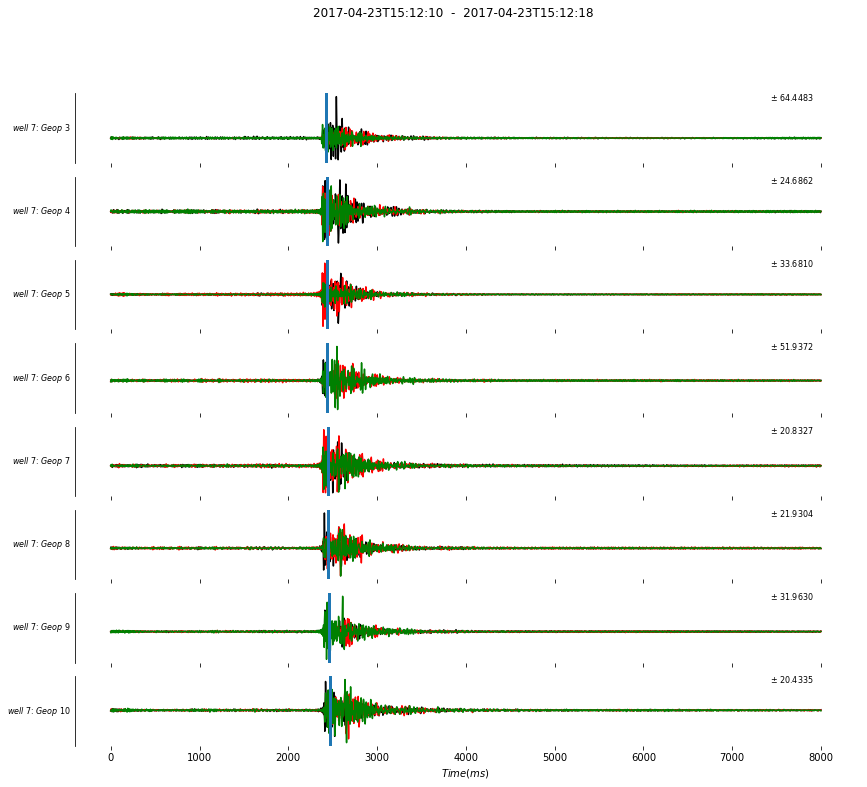

In [4]:
plot_vib_data(data)

P-wave first arrival is wrongly picked by the contractor company
geophone 10 is the deepest and 3 is the shallowest. the interval between one geophone to another is 20 meters.

C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


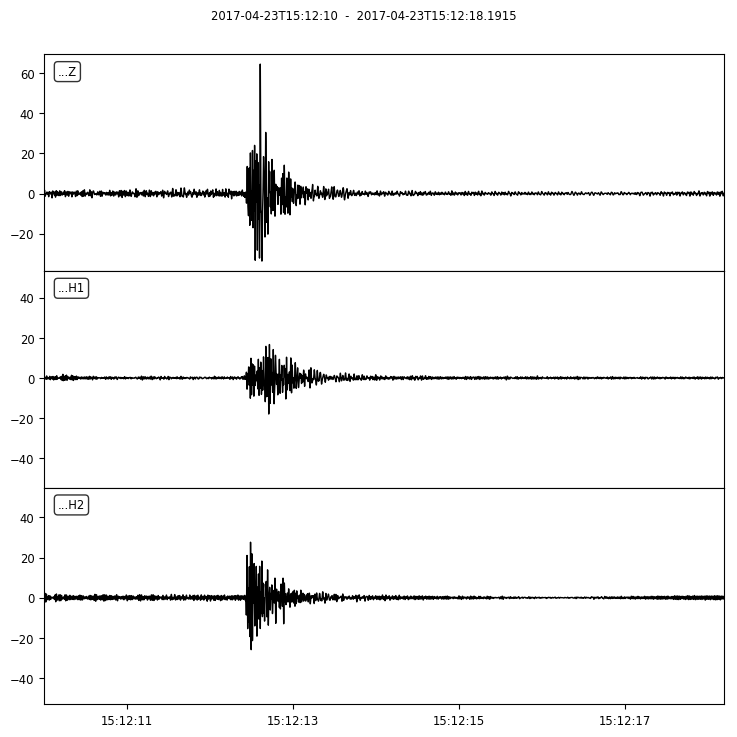

In [5]:
geop3 = data[6:9].copy() #test 3rd geophone

geop3[0].stats.channel = 'Z'
geop3[1].stats.channel = 'H1'
geop3[2].stats.channel = 'H2'

geop3.plot()

(1.5000915583226515, 4.5000305194408838)

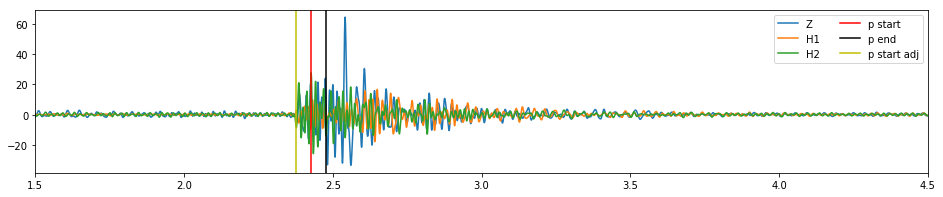

In [6]:
t1 = np.linspace(0, geop3[0].stats.endtime.second - geop3[0].stats.starttime.second,
                        geop3[0].stats.npts, endpoint=True )

p_pick_start = geop3[0].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace/1000000 #micro-sec to sec
p_pick_end = p_pick_start + 0.05

p_pick_start_adjust = p_pick_start -0.05 #-0.05 good for this geophone
p_pick_end_adjust = p_pick_start + 0.05

plt.figure(figsize=(16,3))
plt.plot(t1, geop3[0].data, label = 'Z')
plt.plot(t1, geop3[1].data, label = 'H1')
plt.plot(t1, geop3[2].data, label = 'H2')

plt.axvline(x = p_pick_start, c='r', label = 'p start')
plt.axvline(x = p_pick_end, c ='k', label = 'p end')

plt.axvline(x = p_pick_start_adjust, c='y', label = 'p start adj')
# plt.axvline(x = p_pick_end_adjust, c ='g', label = 'p end adj')

plt.legend(ncol=2)
cut_second =[1.5, 4.5] # cut trace 
plt.xlim(t1[np.argmin(np.abs(t1 - cut_second[0]))], t1[np.argmin(np.abs(t1 - cut_second[1]))])

In [7]:
def detrmine_geophone_orientation(stream):
    '''
    function detrmines geophnes components orientation 
    '''

    azimuth_x = np.arange(0,360, 1)
    result_flinn = []
    result_pm = []
    for azi in azimuth_x:
        if 0 <= azi < 270:
            azimuth_y = azi+90
        else:
            azimuth_y = (azi + 90) - 360
            
        geophone_z = stream[0].data.copy()
        geophone_x = stream[1].data.copy()
        geophone_y = stream[2].data.copy()
        
        t = np.linspace(0, stream[0].stats.endtime.second - stream[0].stats.starttime.second,
                        stream[0].stats.npts, endpoint=True )
        
        pick_start = stream[0].stats.segy.trace_header.x_coordinate_of_ensemble_position_of_this_trace/1000000-0.06
        pick_end = pick_start + 0.05

        
        pw_z = geophone_z[np.argmin(np.abs(t - pick_start)): np.argmin(np.abs(t - pick_end))]
        pw_x = geophone_x[np.argmin(np.abs(t - pick_start)): np.argmin(np.abs(t - pick_end))]
        pw_y = geophone_y[np.argmin(np.abs(t - pick_start)): np.argmin(np.abs(t - pick_end))]
        
        e, n, d = rotate.rotate2zne(pw_x ,azi, 0, pw_y , azimuth_y, 0, pw_z, 0, -90, inverse=False)
        
        e = obspy.Trace(e)
        e.stats = stream[0].stats
        e.stats.channel = 'E'
        n = obspy.Trace(n)
        n.stats = stream[0].stats
        n.stats.channel = 'N'
        d = obspy.Trace(d)
        d.stats = stream[0].stats
        d.stats.channel = 'Z'

        stream1 = obspy.Stream()

        stream1.append(e)
        stream1.append(n)
        stream1.append(d)
        
        flinn = pol.flinn(stream1)
        
        result_flinn.append(flinn)
        
        pm =pol.particle_motion_odr(stream1)
        
        result_pm.append(pm)
        
    return result_flinn, result_pm

            
        

In [8]:
flinn, pm = detrmine_geophone_orientation(geop3) 

In [9]:
azi_flin = list(zip(*flinn))[0]
azi_flin = np.array(azi_flin)

In [10]:
index1 = np.argmin(np.abs(azi_flin - 125))

'''
125 is the true azimuth cacluated in excel between a vector from geophone
3 to geographic north and a vector from geophone 3 to vib location: clockwise
'''


'\n125 is the true azimuth cacluated in excel between a vector from geophone\n3 to geographic north and a vector from geophone 3 to vib location: clockwise\n'

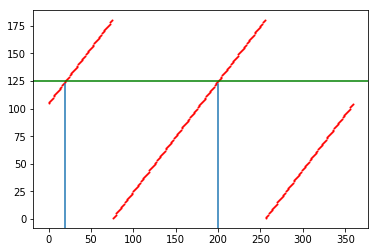

In [11]:
plt.plot(azi_flin, 'or', ms = 1)
plt.axhline(125, c ='g')
plt.axvline(x = index1, ymin = 0, ymax = azi_flin[index1]/plt.ylim()[-1])
plt.axvline(x = index1+180, ymin = 0, ymax =azi_flin[index1+180]/plt.ylim()[-1])

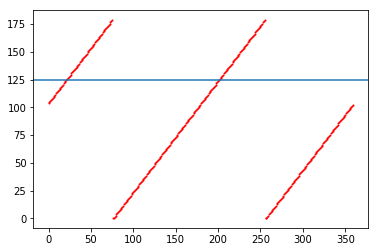

In [12]:
azi_pm = list(zip(*pm))[0]
plt.plot(azi_pm, 'or', ms = 1)
plt.axhline(125)